In [1]:
import math as maths

import cartopy.crs as ccrs
import cartopy.feature as cf
import intake
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import easygems.healpix as egh
import os

savedir = '/home/users/train045/Documents/WCRP25_hackathon/figs/'

import warnings

# Suppress specific FutureWarnings matching the message pattern when using cat[...].to_dask()
warnings.filterwarnings(
    "ignore",
    message=".*The return type of `Dataset.dims` will be changed.*",
    category=FutureWarning,
)

/home/users/train045/miniforge3/envs/wcrp_hackathon/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
cat = intake.open_catalog('https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml')['online']

In [3]:
ds = cat['icon_d3hp003aug'](zoom=11, time='PT15M').to_dask().pipe(egh.attach_coords)

In [4]:
def cells_of_domain(ds, domain_name):
    domain_extents = {"tropics": (0, 360, -30.1, 30.1),}
    lon_min, lon_max, lat_min, lat_max = domain_extents[domain_name]
    cells = ds.cell
    c1 = cells.where(ds.lon>lon_min).where(ds.lon<lon_max).where(ds.lat>lat_min).where(ds.lat<lat_max)
    return c1.dropna('cell')

trop = ds.sel(cell=cells_of_domain(ds, domain_name='tropics')).sel(pressure=slice(10000,100000))

In [5]:
# plot histograms for each resolution

# also, look at (i) arbitrary regions 
# (ii) characterise distribution shape parameters and view globally

# vertical profiles
# CMF... (in cloud... tracking results)

In [6]:
# - vertical profiles

In [7]:
idx = np.random.randint(0, trop.cell.size, 10000)

In [8]:
d = trop.isel(time=0, cell=idx)

In [9]:
# - CMF... 

In [10]:
# calulate density

def density(ds):
    # thermodynamic variables
    p = ds.pressure # Pa (kg m-1 s-2)
    T = ds.ta # K
    Rd = 287.04 # J kg-1 K-1 (m2 s-2 K-1)
    Rv = 461.4 # J kg-1 K-1 (m2 s-2 K-1)
    
    # specific vapour
    q_v = ds.hus # kg kg-1
    
    # ICON model eqn state gives
    q_condensate = ds.qall # kg kg-1
    alpha = ((Rv / Rd) - 1) * q_v - q_condensate
    rho = p / (Rd * T * (1 + alpha)) # kg m-3
    return rho

In [11]:
rho = density(d)

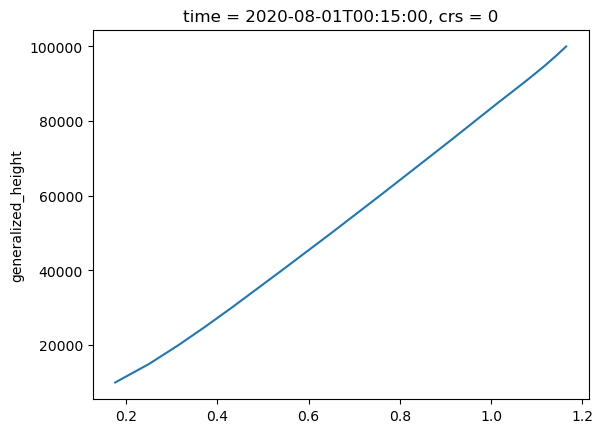

In [12]:
rho.mean('cell').plot(y='pressure')

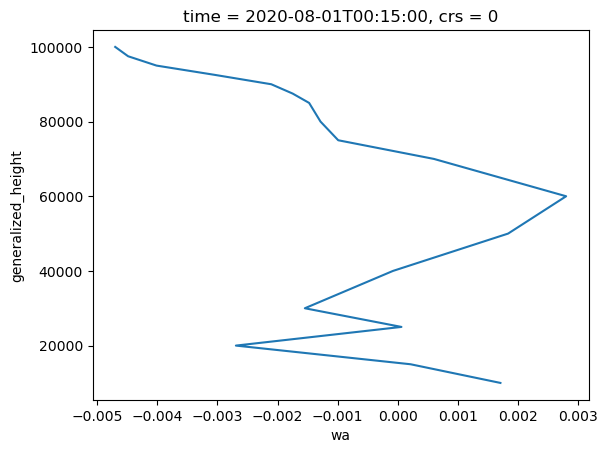

In [13]:
d.wa.mean('cell').plot(y='pressure')

In [14]:
# calculate CMF

cmf = d.wa * rho # kg s-1 m-2

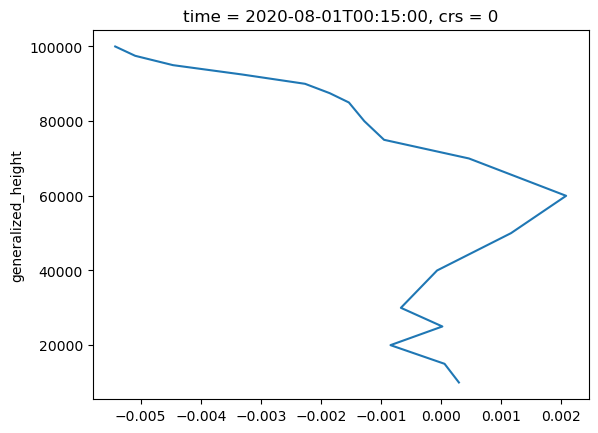

In [15]:
cmf.mean('cell').plot(y='pressure')

In [16]:
d.pressure.diff('pressure')

<xarray.DataArray 'pressure' (pressure: 17)> Size: 136B
array([ 5000,  5000,  5000,  5000, 10000, 10000, 10000, 10000,  5000,
        5000,  5000,  2500,  2500,  2500,  2500,  2500,  2500])
Coordinates:
  * pressure  (pressure) int64 136B 15000 20000 25000 ... 95000 97500 100000
    time      datetime64[ns] 8B 2020-08-01T00:15:00
    crs       int64 8B 0

In [18]:
# vertical (upward) integral

del_p = d.pressure.diff('pressure') # Pa
g = 9.8 # m/s

cmf_I = (1 / g * (d.wa * np.abs(del_p))).sum('pressure')

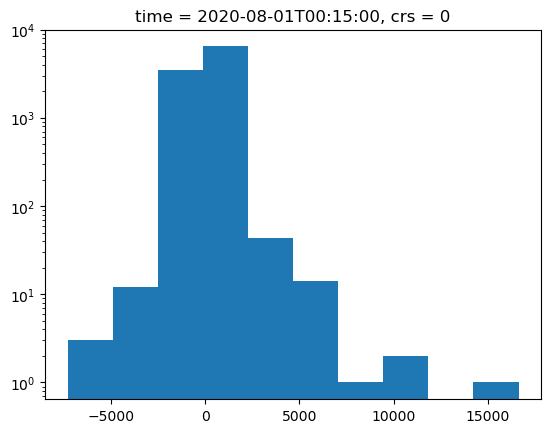

In [19]:
cmf_I.plot.hist()
plt.yscale('log')

In [5]:
w = trop.isel(time=0).isel(cell=slice(0,100)).wa.sel(pressure=slice(10000, 100000)).data.flatten()
w

array([ 0.00919822,  0.07212433, -0.02544744, ..., -0.08707961,
        0.1035009 , -0.05407505], shape=(1800,), dtype=float32)